In [1]:
import numpy as np
import matplotlib.pyplot as plt

from copy import deepcopy

from data import exemplars, load_noisy_data

In [79]:
class RestrictedBoltzmannMachine:
    def __init__(self, n_visible: int, n_hidden: int):
        '''
        Initialize 2 Layer Restricted Boltzmann Machine with a specified number of hidden nodes and visible nodes.

        Arguments:
          n_visible (int) - Number of nodes in the visible layer
          n_hidden  (int) - Number of nodes in the hidden layer
        '''
        self.n_visible = n_visible
        self.n_hidden  = n_hidden
        self.W = np.random.normal(0.0, 1.0, (n_visible, n_hidden)) # Set to this for testing purposes - np.array([[2, -1, 1], [-2, 0, -1]])
        self.a = np.random.normal(0.0, 1.0, n_visible)
        self.b = np.random.normal(0.0, 1.0, n_hidden)

        
    def sigmoid(self, x):
        '''
        Activation function for output of nodes in either layer.
        '''
        return 1 / (1 + np.exp(-x))
    
    def reconstruct_hidden_layer(self, visible_input):
        # Calculate hidden probabilities
        activation = np.vectorize(self.sigmoid)
        hidden_probas = activation(np.inner(visible_input, self.W) + self.a)

        # Sample hidden layer output from calculated probabilties
        random_vars = np.random.random(size=self.n_hidden) # Set to this for testing purposes - np.array([0.87, 0.14, 0.64]) 
        return (random_vars < hidden_probas).astype(int)

    def reconstruct_visible_layer(self, hidden_input):
        # Calculate visible probabilities
        activation = np.vectorize(self.sigmoid)
        visible_probas = activation(np.inner(hidden_input, self.W) + self.b)

        # Sample visible layer output from calculated probabilties
        random_vars = np.random.random(size=self.n_visible) # Set to this for testing purposes - np.array([0.25, 0.72])
        return (random_vars < visible_probas).astype(int)
    
    def train(self, patterns, eta=0.01, epochs=10):
        for _ in range(epochs):
            for v in patterns:
                # Take training sample, and comput probabilties of hidden units and the
                # sample a hidden activation vector from this probability distribution
                h = self.reconstruct_hidden_layer(v)

                # Compute the outer product of v and h and call this the positive gradient
                pos_grad = np.outer(v, h)

                # From h, sample a reconstruction v' of the visible units
                v_prime = self.reconstruct_visible_layer(h)
                
                # Then resample activations h' from this
                h_prime = self.reconstruct_hidden_layer(v_prime)

                # Compute the outer product of v' and h' and call this the negative gradient
                neg_grad = np.outer(v_prime, h_prime)
               
                W_delta = eta*(pos_grad.T - neg_grad.T) # Update to the weight matrix W, will be the positive gradient minus the negative gradient, times some learning rate
                a_delta = eta*(v - v_prime) # Update to the visible bias
                b_delta = eta*(h - h_prime) # Update to the hidden bias

                self.W = np.add(self.W, W_delta)
                self.a = np.add(self.a, a_delta)
                self.b = np.add(self.b, b_delta)

        
    def recall(self, pattern, iters=100):
        v = deepcopy(pattern)
        for _ in range(iters):
            h = self.reconstruct_hidden_layer(v)
            v = self.reconstruct_visible_layer(h)
        
        return v

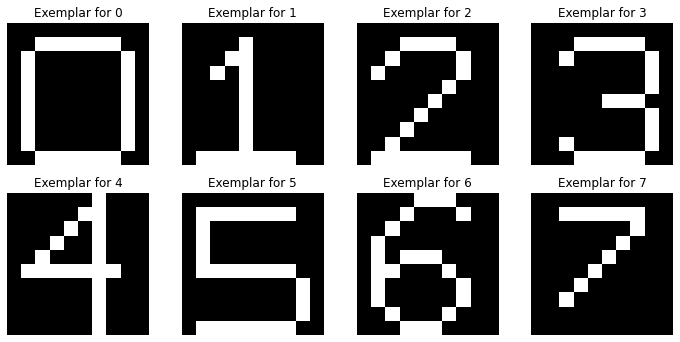

In [80]:
plt.figure(1, figsize=(12,12))
for i in range(len(exemplars)):
    exemplar = exemplars[i].reshape(10, 10)
    plt.subplot(4, 4, i+1)
    plt.imshow(exemplar, cmap='gray')
    plt.title(f'Exemplar for {i}')
    plt.axis('off')

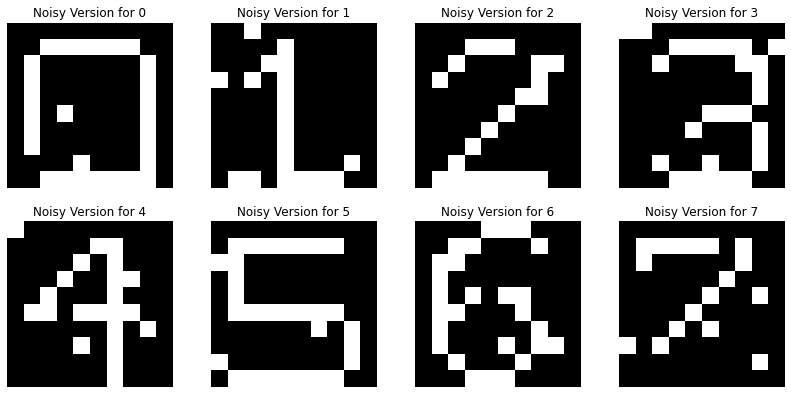

In [98]:
noisy_data = load_noisy_data(threshold=0.95)

plt.figure(1, figsize=(14,14))
for i in range(len(noisy_data)):
    noisy = noisy_data[i].reshape(10, 10)
    plt.subplot(4, 4, i+1)
    plt.title(f'Noisy Version for {i}')
    plt.imshow(noisy, cmap='gray')
    plt.axis('off')

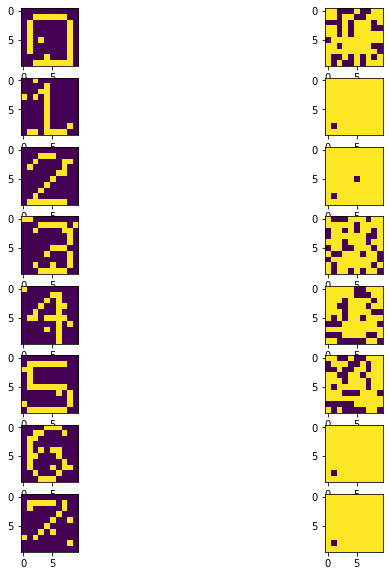

In [99]:
start_offset = 0
end_offset = 8
idxs = [i for i in range(start_offset, end_offset)]
rbm = RestrictedBoltzmannMachine(100, 100)
rbm.train(exemplars[start_offset:end_offset], eta=0.001, epochs=1000)
fig, axs = plt.subplots(len(idxs), 2, figsize=(10, 10))
for i in range(len(idxs)):
    num = idxs[i]
    axs[i, 0].imshow(noisy_data[num].reshape(10, 10))
    axs[i, 1].imshow(rbm.recall(noisy_data[num], iters=20).reshape(10, 10));